<a href="https://colab.research.google.com/github/abhyagarg22/GAN/blob/main/Basics_of_Gan_and_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T090217Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40e1b72760809d845abe63f9cc34393b95d7613585451d614dbad6620503772b25cf03a259fe25946f21146804a3449b38f54ea2ee091bba1d2a6a96509bf84f4cc0ae912dcf1d58d997428c46ae8267d9bae075be713a43651b999a2ada05122e414566349c806aae18fd1cda0ca9e49e36c3c57b72f120626ce6610d7e65be21e8e7b593d0f1e1f048ae219f5175cc39a84aacc7f160528dfdfd9a670a4756099eb175c465b09b9d505cdadd009ebef316da8a11974358c3ebd1d5aa8b2009fb79f5cdafe252c316a0e9887728c5a5484dbbcca73d9e42f35565ab27dbafd285d862c4aefeb2c5d3332857aa517427d46a9a6cf70b9da9c88b3117a90efdfd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Generative Adverserial Networks**


Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.


![Generative-Adversarial-Networks-Framework.png](attachment:Generative-Adversarial-Networks-Framework.png)



While most deep generative models are trained by maximizing log likelihood or a lower bound on log likelihood, GANs take a radically different approach that does not require inference or explicit calculation of the data likelihood. Instead, two models are used to solve a minimax game: a generator which samples data, and a discriminator which classifies the data as real or generated.In theory these models are capable of modeling an arbitrarily complex probability distribution.








# **Objective**

The objective of this notebook is to introduce beginners to the underlying concept of Generative Adversarial Networks (GANs) in the most intuitive way possible. The aim is to describe the working of such network without delving deep into the complex mathematics associated and in a more practical way such that the viewer can develop his own simple GAN.

A simple GAN is first constructed here with only hidden dense layers and tries to output meaningful images. The output is analysed discovering one particular issue which is commonplace in simple GANs. The issue is resolved in the next part with one particular type of GAN called Deep Convolution Generative Adversarial Networks (DCGANs) .

# **Introduction**


GANs are made up of two components -

1. **Generator - generates new data instances**

2. **Discriminator - tries to distinguish the generated or fake data from the real dataset.**

Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs. So discriminative algorithms map features to labels. They are concerned solely with that correlation.One the other way,loosely speaking,generative algorithms do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

While training they both start together from scratch and the generator learn to shape the random distribition through the training epochs.

# **Working Principle**

**Generative** network is fed noise may be in the form a random distribution and generates fake data from the noise. The fake data from the generator is input to the discriminator. Once the training is complete, the generator should be able to generate real like data from the noises.

The interesting fact here is that the generator learns to produce meaningful images without even actually looking at the image.

![1_CkMMefLPqcEKPuuPLZY2_Agg.png](attachment:1_CkMMefLPqcEKPuuPLZY2_Agg.png)

**Discriminator** or the adversarial network works as the opponent to the generator. It is basically a  classifier or discriminator whose function is to distinguish between two different classes of data. Here the classes are real data (labelled as 1) and the fake data the generator produces (labelled as 0).



# **Training the network**

The important thing about training a GAN is that the two components should never be trained together. Rather the network is trained in two different phases,the first phase is for training the discriminator and updating the weights appropriately and in the next step the generator is trained while the discriminator training is disabled.

**Phase 1**
During phase one of training the generator is fed random data(in the form of a distribution) as noise. The generator creates some random images which are given to the discriminator. The discriminator also takes input from dataset of real images.
The discriminator learns to distinguish the real data from the fake ones by learning or assessing features from it's inputs. The discriminator outputs some probability and difference between the predicted results and the actual results are backpropagated through the network and the weights of the discriminator is updated.
Remember during this phase, the backpropagation stops at the end of the discriminator and the generator is not trained or updated.


**Phase 2**
In this phase, the generator produced batch of images are directly given as input to the discriminator. The real images are not given this time to the discriminator. The generator learns by tricking the discriminator into it outputting false positives. The discriminator outputs probabilities which are assessed against the actual results and the weights of of the generator are updated through backpropagation.
Remember here during backpropagation, the discriminator weights should not be updated and kept as they were before.

![Train1_t82vgL9KcDVpT4JqCb9Q4Q.png](attachment:Train1_t82vgL9KcDVpT4JqCb9Q4Q.png)

**LOSS FUNCTION of simple GAN**

In the paper that introduced GANs(link below in the reference), the generator tries to minimize the following function while the discriminator tries to maximize it:

![loss.png](attachment:loss.png)
In this function:

* D(x) is the discriminator's estimate of the probability that real data instance x is real.
* Ex is the expected value over all real data instances.
* G(z) is the generator's output when given noise z.
* D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.
* Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).


The generator can't directly affect the log(D(x)) term in the function, so, for the generator, minimizing the loss is equivalent to minimizing log(1 - D(G(z))).

**Applications of GANs**

* Generate Examples for Image Datasets
* Generate Photographs of Human Faces
* Generate Realistic Photographs
* Image-to-Image Translation
* Text-to-Image Translation
* Semantic-Image-to-Photo Translation
* Photos to Emojis
* Face Aging
* Super Resolution
* 3D Object Generation


![sr.jpg](attachment:sr.jpg)

# **Problems with simple GANs**

In practice, however, GANs suffer from many issues, particularly during training. One common
failure mode involves the generator collapsing to produce only a single sample or a small family of
very similar samples. In this case, the generator learns to trick the discriminator with a single image or a few images to believe as real image. Another involves the generator and discriminator oscillating during training,rather than converging to a fixed point. In addition, if one agent becomes much more powerful than the other, the learning signal to the other agent becomes useless, and the system does not learn.
To train GANs many tricks must be employed,one such method is using Deep Convolution Generative Adversarial Networks as discussed in a research paper published in 2016 (link in the references).




# **Let's begin**

In [ ]:
from glob import glob
from PIL import Image
from IPython import display
import tensorflow.keras as kr
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 1000

In [ ]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

        image = imageio.imread(filename)
        writer.append_data(image)

    # this is a hack to display the gif inside the notebook
    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [ ]:
def sample_images(generator, epoch, save=True, name='mnist'):
    """ Sample images from generator, plot them and save as png"""

    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            c += 1

    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

In [ ]:
(X, _), (_, _) = kr.datasets.mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

# The Generator Model
The generator will try to create images that are good enough to fool the discriminator. First, we are going to start with a simple model - with Dense layers -.

In [ ]:
def build_generator(output_shape=(28, 28, 1)):
    model = kr.Sequential(name='generator')

    model.add(kr.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(1024))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.BatchNormalization(momentum=0.8))

    model.add(kr.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(kr.layers.Reshape(output_shape))

    return model


generator = build_generator()
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

# The Discriminator model

The discriminator will try to distinguish fake images from real images

In [ ]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = kr.Sequential(name='discriminator')

    model.add(kr.layers.Flatten(input_shape=input_shape))
    model.add(kr.layers.Dense(512))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(256))
    model.add(kr.layers.LeakyReLU(alpha=0.2))

    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator
z = kr.Input(shape=(LATENT_DIM,))
valid = discriminator(generator(z))
model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Sequential)          │ (None, 28, 28, 1)      │     1,493,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Sequential)      │ (None, 1)              │       533,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,025 (7.73 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 537,089 (2.05 MB)

In [ ]:
# Adversarial ground truths
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))

    # Shuffle and batch data
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)]

    # Train the discriminator
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)

    # Unpack losses if they are lists
    if isinstance(loss_real, (list, tuple)):
        loss_real = loss_real[0]
    if isinstance(loss_fake, (list, tuple)):
        loss_fake = loss_fake[0]
    d_loss = 0.5 * (loss_real + loss_fake)
    # Train the generator
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)

    # Unpack generator loss if it is a list
    if isinstance(g_loss, (list, tuple)):
        g_loss = g_loss[0]

    # Clear the previous output and print the current epoch's results
    display.clear_output(wait=True)
    print(f"Epoch: {epoch} [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}]")

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/mnist')

Epoch: 999 [D loss: 3.476411] [G loss: 3.477346]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


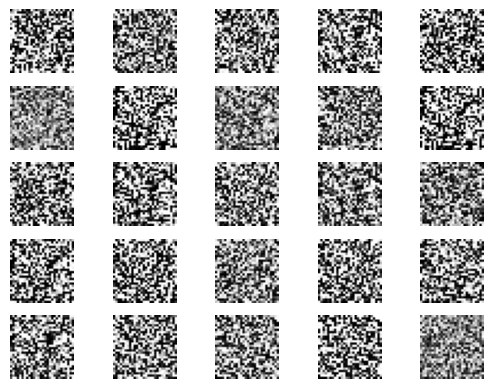

In [ ]:
sample_images(generator, None, save=False)

/tmp/ipykernel_34/3099421260.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_34/3099421260.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


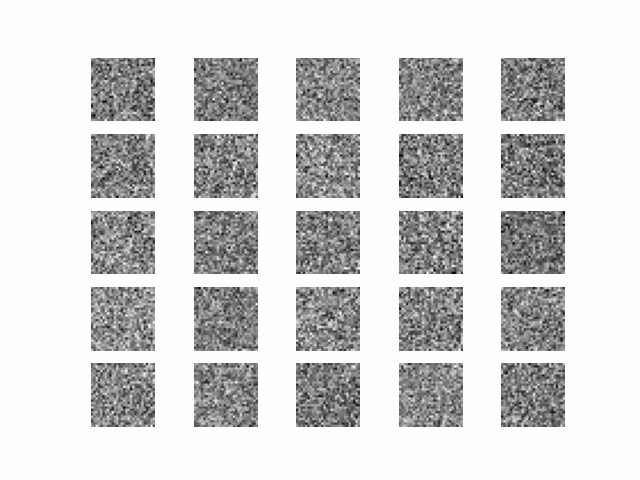

In [ ]:
generate_gif(gif_name='../working/mnist_gan.gif', pattern='../working/mnist*.png')
display.Image(filename="../working/mnist_gan.gif.png")

# DC-GAN with Fashion MNIST
Now, let's change our data to Fashion MNIST to generate clothes meanwhile using the Deep Convolutional GAN model.

In [ ]:
(X, _), (_, _) = kr.datasets.fashion_mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# The Generator

In [ ]:
def generator_model():
    model = kr.Sequential()

    model.add(kr.layers.Dense(7 * 7 * 128, activation="relu", input_shape=(LATENT_DIM,)))
    model.add(kr.layers.Reshape((7, 7, 128)))

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.UpSampling2D())
    model.add(kr.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.ReLU())

    model.add(kr.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'))

    return model


generator = generator_model()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,193 (3.27 MB)

 Trainable params: 855,809 (3.26 MB)

 Non-trainable params: 384 (1.50 KB)

# The Discriminator

In [ ]:
def discriminator_model():
    model = kr.Sequential()

    model.add(kr.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(kr.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(kr.layers.BatchNormalization(momentum=0.8))
    model.add(kr.layers.LeakyReLU(alpha=0.2))
    model.add(kr.layers.Dropout(0.25))

    model.add(kr.layers.Flatten())
    model.add(kr.layers.Dense(1, activation='sigmoid'))

    return model


discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,657 (1.49 MB)

 Trainable params: 389,761 (1.49 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
optimizer = kr.optimizers.Adam(0.0002, 0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False    # For GAN we will only train the generator

z = kr.Input(shape=(LATENT_DIM,))
valid = discriminator(generator(z))

model = kr.Model(z, valid)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28, 1)      │       856,193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1)              │       390,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,246,850 (4.76 MB)

 Trainable params: 855,809 (3.26 MB)

 Non-trainable params: 391,041 (1.49 MB)

In [ ]:
valid_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))

    # Shuffle and batch data
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)]

    # Train the discriminator on real and fake data
    loss_real = discriminator.train_on_batch(imgs, valid_labels)
    loss_fake = discriminator.train_on_batch(generator.predict(noise), fake_labels)

    # Ensure losses are single values
    if isinstance(loss_real, (list, tuple)):
        loss_real = loss_real[0]
    if isinstance(loss_fake, (list, tuple)):
        loss_fake = loss_fake[0]

    d_loss = 0.5 * (loss_real + loss_fake)

    # Train the generator
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    g_loss = model.train_on_batch(noise, valid_labels)

    # Ensure g_loss is a single value
    if isinstance(g_loss, (list, tuple)):
        g_loss = g_loss[0]

    # Clear the previous output and print the current epoch's results
    display.clear_output(wait=True)
    print(f"Epoch: {epoch} [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}]")

    # If at save interval => save generated image samples
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/fmnist')


Epoch: 776 [D loss: 0.794550] [G loss: 0.794602]


In [ ]:
sample_images(generator, None, save=False, name='../working/fmnist')

# **References**

1. https://arxiv.org/abs/1406.2661 - GANs paper in 2014 by Ian J. Goodfellow and others.
2. https://arxiv.org/abs/1511.06434 - DCGANs in 2016
3. https://arxiv.org/pdf/1611.02163.pdf - 2017 ICLR paper
4. https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29